In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
color = sns.color_palette()
%matplotlib inline

In [4]:
df = pd.read_csv('cryptocurrencypricehistory-daily/bitcoin_price.csv')

In [5]:
df = df[::-1]

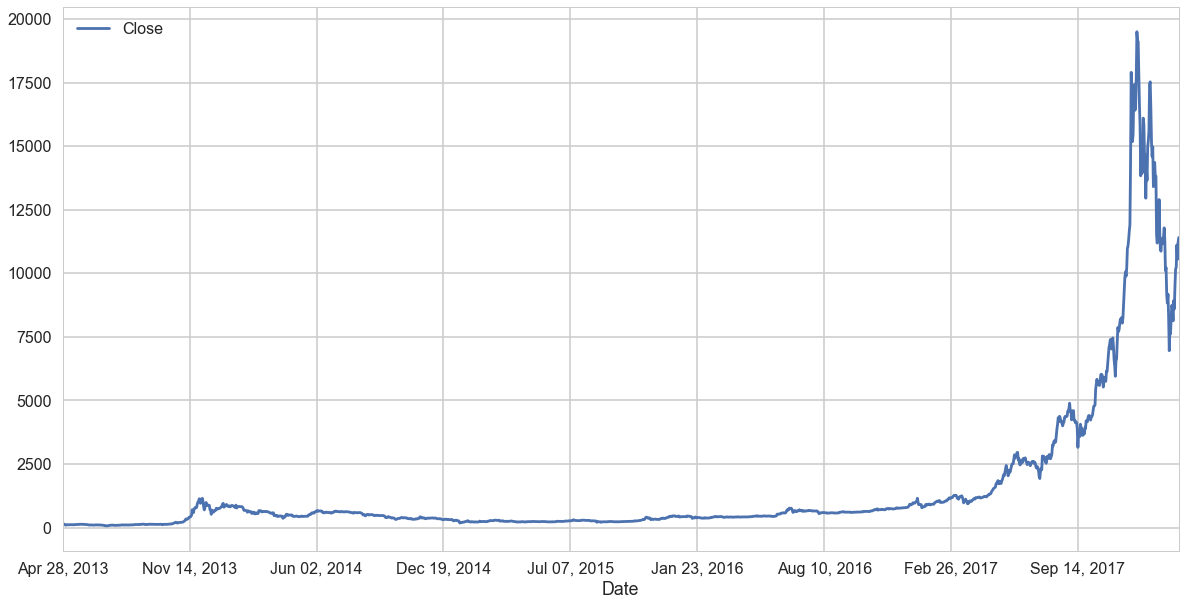

In [9]:
df.plot('Date', 'Close', figsize=(20,10))

In [739]:
price = df.Close.values

## Kalman Filter & EM Algorithm

E-step:
M-step:


In [10]:
def kalman_filter(y, sigma_eps, sigma_gamma, mu_init, sigma_init):
    T = len(y)
    mu = [mu_init]
    sigma = [sigma_init]
    for t in range(T):
        mu.append(mu[-1] + (sigma_eps + sigma[-1]) / (sigma_eps + sigma[-1] + sigma_gamma)*(y[t] -  mu[-1]))
        sigma.append(1/(1 / (sigma[-1] + sigma_eps) + 1 / sigma_gamma))
    return mu, sigma

In [11]:
def kalman_smoother(y, x_filter, sigma_filter, sigma_eps, sigma_gamma):
    T = len(y)
    mu = [x_filter[-1]]
    sigma = [sigma_filter[-1]]
    for t in range(1, T + 1):
        mu.append(x_filter[T - t] + sigma_filter[T - t]/(sigma_filter[T - t] + sigma_eps) * (mu[-1] - x_filter[T - t]))
        sigma.append((sigma_filter[T - t]/(sigma_filter[T - t] + sigma_eps))**2 * sigma[-1] + sigma_filter[T-t]/(sigma_filter[T - t] + sigma_eps) * sigma_eps)
    return mu, sigma

In [12]:
def E_step(y, sigma_eps, sigma_gamma, mu_init, sigma_init):
    x_filter, sigma_filter = kalman_filter(y, sigma_eps, sigma_gamma, mu_init, sigma_init)
    x_smoother, sigma_smoother = kalman_smoother(y, x_filter, sigma_filter, sigma_eps, sigma_gamma)
    
    return x_smoother[::-1], x_smoother[0], sigma_smoother, sigma_filter

In [13]:
def M_step(y, x_smoother, sigma_smoother, sigma_filter, sigma_eps_old):
    T = len(y)
#     sigma_eps = sum((x_smoother[1:] - x_smoother[:T]) ** 2)/T
#     sigma_gamma = sum((y - x_smoother[1:])**2)/(T + 1)

    W = x_smoother ** 2 + sigma_smoother
    W_cov = x_smoother[1:] * x_smoother[:T] \
            + sigma_filter[:T]/(sigma_filter[:T] + sigma_eps_old) * sigma_smoother[1:]
    
    sigma_eps = sum(W[1:] + W[:T] - 2 * W_cov)/T
    sigma_gamma = sum(y ** 2 + x_smoother[1:]**2 + sigma_smoother[1:] - 2 * y * x_smoother[1:])/(T + 1)

    return sigma_eps, sigma_gamma

In [14]:
def EM(y):
    sigma_eps_old = 0.08
    sigma_gamma_old = 0.8
    sigma_eps = 0.2
    sigma_gamma = 1
    mu_init = y[0]
    sigma_init = 0.1
    sigma_eps_ls = []
    sigma_gamma_ls = []
    while np.abs(sigma_eps_old - sigma_eps) > 1e-6 or np.abs(sigma_gamma_old - sigma_gamma) > 1e-6:
        sigma_eps_old = sigma_eps
        sigma_gamma_old = sigma_gamma
        x_smoother,mu_init,sigma_smoother, sigma_filter = E_step(y, sigma_eps, sigma_gamma, mu_init, sigma_init)
        sigma_eps, sigma_gamma = M_step(y, np.array(x_smoother), np.array(sigma_smoother), np.array(sigma_filter), sigma_eps_old)
        sigma_eps_ls.append(sigma_eps)
        sigma_gamma_ls.append(sigma_gamma)
    
    return x_smoother, sigma_eps_ls, sigma_gamma_ls

In [15]:
x_smoother, sigma_eps_ls, sigma_gamma_ls= EM(price[:1500])

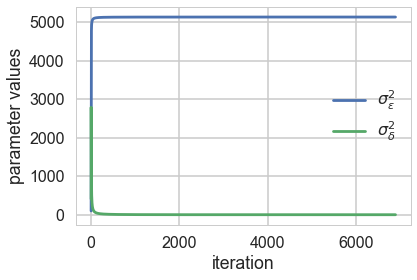

In [26]:
plt.plot(sigma_eps_ls, label = '$\sigma^2_{\epsilon}$')
plt.plot(sigma_gamma_ls, label = '$\sigma^2_{\delta}$')
plt.xlabel("iteration")
plt.ylabel("parameter values")
plt.legend()

In [29]:
x_filter, sigma_filter = kalman_filter(price[:1759], sigma_eps_ls[-1],  sigma_gamma_ls[-1], price[0], sigma_gamma_ls[-1])

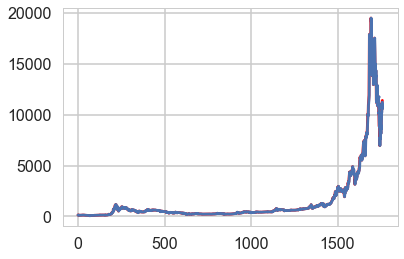

In [31]:
plt.errorbar(range(len(x_filter)), x_filter, yerr= 2 * np.sqrt(sigma_filter))
plt.plot(price[:1760], 'r')

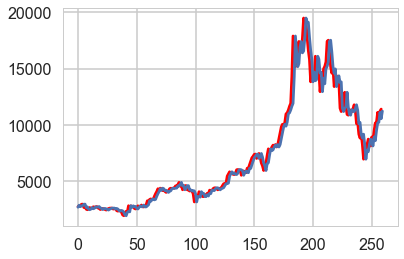

In [36]:
plt.errorbar(range(len(x_filter[1500:])), x_filter[1500:], yerr= 2 * np.sqrt(sigma_filter[1500:]))
plt.plot(price[1501:1760], 'r')

In [40]:
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(price[:1500], x_filter[:1500]))
print('Train Score: %.6f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(price[1500:], x_filter[1500:]))
print('Test Score: %.6f RMSE' % (testScore))

Train Score: 28.065886 RMSE
Test Score: 593.450079 RMSE


In [1257]:
pred = []
for t in range(260):
    x_smoother, sigma_eps_ls, sigma_gamma_ls= EM(price[1480 + t:t + 1500])
    pred.append(x_smoother[-1])

In [1259]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(pred, price[1500:]))

593.4495335241405

## LSTM

In [262]:
# compare with lstm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [1261]:
# split into train and test sets
train_size = 1500
test_size = len(price) - train_size
train, test = price.reshape(-1, 1)[0:train_size], price.reshape(-1, 1)[train_size:len(price)]
print(len(train), len(test))

1500 260


In [1262]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [1263]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [1264]:
# reshape into X=t and Y=t+1
look_back = 1
train = create_dataset(train, look_back)
test = create_dataset(test, look_back)

In [1265]:
trainX = train[0]
trainY = train[1]
testX = test[0]
testY = test[1]

In [1266]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [1283]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [1288]:
model.fit(trainX, trainY, epochs=3, batch_size=32, verbose=2)

Epoch 1/3
 - 0s - loss: 0.0054
Epoch 2/3
 - 0s - loss: 0.0025
Epoch 3/3
 - 0s - loss: 8.0549e-04


In [1289]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [1290]:
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.6f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.6f RMSE' % (testScore))

Train Score: 0.018891 RMSE
Test Score: 0.228784 RMSE


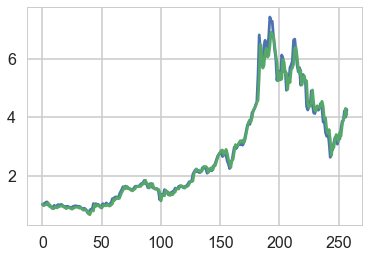

In [1291]:
plt.plot(testY)
plt.plot(testPredict)

In [1292]:
trainScore = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(1,-1)), scaler.inverse_transform(trainPredict.reshape(1,-1))))
print('Train Score: %.6f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(1,-1)), scaler.inverse_transform(testPredict.reshape(1,-1))))
print('Test Score: %.6f RMSE' % (testScore))

Train Score: 49.464597 RMSE
Test Score: 599.043430 RMSE


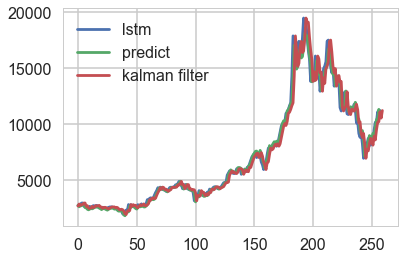

In [1300]:
plt.plot(scaler.inverse_transform(testY.reshape(1,-1))[0], label  = 'lstm')
plt.plot(scaler.inverse_transform(testPredict.reshape(1,-1))[0], label = 'predict')
plt.plot(pred, label = 'kalman filter')
plt.legend()

In [1314]:
df_new = df.iloc[1502:]

In [1316]:
df_new['kf'] = pred[2:]

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1317]:
df_new['lstm'] = scaler.inverse_transform(testY.reshape(1,-1))[0]

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


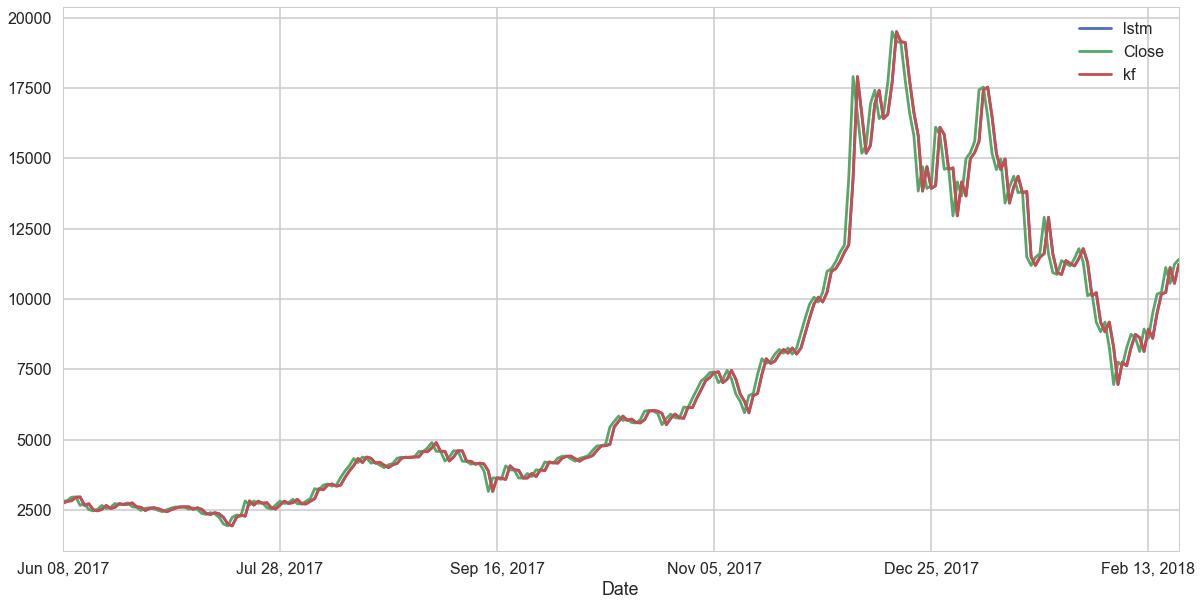

In [1325]:
ax1 = df_new.plot('Date', 'lstm', figsize=(20,10))
ax2 = df_new.plot('Date', 'Close', figsize=(20,10), ax = ax1)
ax3 = df_new.plot('Date', 'kf', figsize=(20,10), ax = ax2)